This is based on https://smorabit.github.io/tutorials/8_velocyto/

In [12]:
import scvelo as scv
import pandas as pd
import numpy as np
import anndata
from scipy.io import mmread

In [211]:
print(vel_data.obsm['X_umap'])

                    UMAP_1    UMAP_2
AAACCTGCAAACTGCT -3.354277  2.695674
AAACCTGGTTAGTGGG -1.634298  0.273384
AAACGGGAGCAGGTCA  3.192059  0.201688
AAACGGGAGCGACGTA -1.967078  2.358909
AAACGGGAGCTGTTCA  1.094599  2.127877
...                    ...       ...
TTTCCTCCAATCCAAC  5.337360 -5.749457
TTTCCTCGTATAGGGC -4.151823 -0.992374
TTTGCGCCACACAGAG  5.363075 -5.087383
TTTGTCACAGATGGGT -2.762006  3.213490
TTTGTCAGTTGCGCAC -0.722546  2.400010

[961 rows x 2 columns]


In [236]:
loom_dir = 'RNA_velocity/'
data_dir = 'exported_matrices/'

datasets = pd.read_csv("datasets.csv", index_col=None)


def convert_to_AnnData(dataset: str, verbose: bool = True) -> anndata.AnnData:
    """ 
    Loads the velocity data for a given dataset.

    Parameters
    ----------
    dataset : str
        The dataset to load.
    verbose : bool
        Whether to print out progress information, defaults to True.

    Returns
    -------
    adata : anndata.AnnData
        The AnnData object containing the expression and velocity data.    
    """

    # Start by merging the loom files
    filtered_datasets = datasets[datasets['study_id'] == dataset]
    loom_filenames = [f"{row['study_id']}_{row['source']}" for _,
                      row in filtered_datasets.iterrows()]

    vel_data = None
    num_removed = 0

    for i, filename in enumerate(loom_filenames):
        if verbose:
            print(f"Loading {filename}.loom")
        if i == 0:
            vel_data = scv.read(f"{loom_dir}{filename}.loom", cache=False)
            scv.utils.clean_obs_names(
                vel_data, id_length=16, alphabet="[ACGT]", inplace=True)
            vel_data.var_names_make_unique()

            # Only select genes in the adata object
            vel_data = vel_data[:, adata.var_names]
        else:
            vel_data2 = scv.read(f"{loom_dir}{filename}.loom", cache=False)
            scv.utils.clean_obs_names(
                vel_data2, id_length=16, alphabet="[ACGT]", inplace=True)

            common_barcodes = np.intersect1d(
                vel_data.obs.index, vel_data2.obs.index)

            # Remove barcodes that are in both datasets from the second dataset, otherwise scv.utils.merge will fail
            # This is not perfect, but it's a very small number of barcodes
            vel_data2 = vel_data2[~vel_data2.obs.index.isin(common_barcodes)]
            num_removed += len(common_barcodes)

            vel_data2.var_names_make_unique()
            vel_data2 = vel_data2[:, adata.var_names]
            vel_data = vel_data.concatenate(vel_data2, index_unique=None)

    # Add metadata and dimensionality reductions

    if verbose:
        print(f"Removed {num_removed} barcodes that were in multiple datasets")
        print(f"Final shape: {vel_data.shape}")

    count_matrix = mmread(f"{data_dir}{dataset}_counts.mtx")
    counts_with_genes = pd.read_csv(
        f"{data_dir}{dataset}_counts.csv", index_col=0)
    gene_names = counts_with_genes.index.values

    metadata = pd.read_csv(f"{data_dir}{dataset}_metadata.csv", index_col=None)
    pca = pd.read_csv(f"{data_dir}/{dataset}_pca.csv", index_col=None)
    pca['Barcode'] = [bc.split("-")[0] for bc in pca['Barcode']]
    umap = pd.read_csv(f"{data_dir}/{dataset}_umap.csv", index_col=None)
    clusters = pd.read_csv(
        f"{data_dir}/{dataset}_clusters.csv", index_col=None)

    vel_barcodes = vel_data.obs.index
    vel_data.var.index = gene_names

    pca['Barcode'] = [x.split('-')[0] for x in pca['Barcode']]
    pca = pca.drop_duplicates(subset=['Barcode'])
    pca = pca[pca['Barcode'].isin(vel_barcodes)]
    pca = pca.set_index('Barcode', drop=True)
    pca = pca.reindex(vel_barcodes)

    umap['Barcode'] = [x.split('-')[0] for x in umap['Barcode']]
    umap = umap.drop_duplicates(subset=['Barcode'])
    umap = umap[umap['Barcode'].isin(vel_barcodes)]
    umap = umap.set_index('Barcode', drop=True)
    umap = umap.reindex(vel_barcodes)

    clusters['Barcode'] = [x.split('-')[0] for x in clusters['Barcode']]
    clusters = clusters.drop_duplicates(subset=['Barcode'])
    clusters = clusters[clusters['Barcode'].isin(vel_barcodes)]
    clusters = clusters.set_index('Barcode', drop=True)
    clusters = clusters.reindex(vel_barcodes)

    vel_data.obsm['X_pca'] = pca
    vel_data.obsm['X_umap'] = np.vstack(
        (umap['UMAP_1'].values, umap['UMAP_2'].values)).T
    vel_data.obs["cluster"] = [f"C{c}" for c in clusters['Cluster']]
    vel_data.obs["cluster"] = vel_data.obs["cluster"].astype("category")

    return vel_data


adata = convert_to_AnnData("Ruf_Zamojski2021F")
print(adata)

Loading Ruf_Zamojski2021F_SRR11945353.loom
Loading Ruf_Zamojski2021F_SRR11945364.loom
Loading Ruf_Zamojski2021F_SRR11945365.loom
Loading Ruf_Zamojski2021F_SRR11945366.loom
Removed 1582 barcodes that were in multiple datasets
Final shape: (1584, 11103)
AnnData object with n_obs × n_vars = 1584 × 11103
    obs: 'batch', 'cluster'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    obsm: 'X_pca', 'X_umap'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'


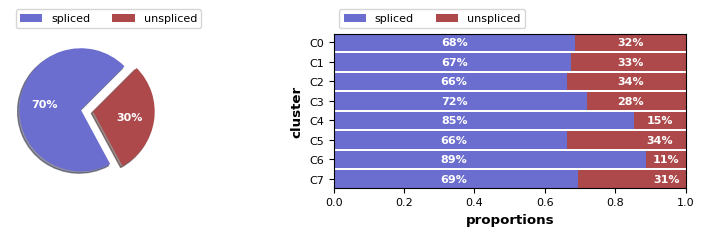

In [237]:
scv.pl.proportions(adata, groupby='cluster')

In [238]:
scv.pp.filter_and_normalize(adata)
scv.pp.moments(adata)
scv.tl.velocity(adata, mode='stochastic')
scv.tl.velocity_graph(adata)

Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/16 cores)


  0%|          | 0/1584 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


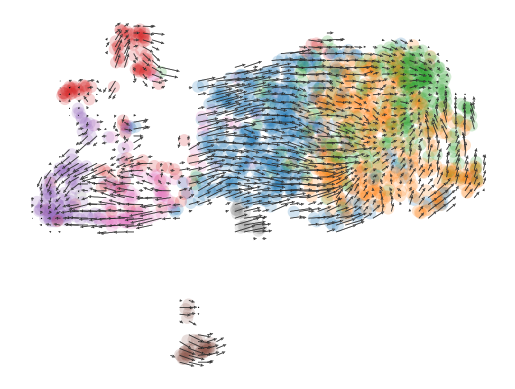

In [239]:
scv.pl.velocity_embedding_grid(adata, basis='umap', color='cluster', title='', scale=0.25)

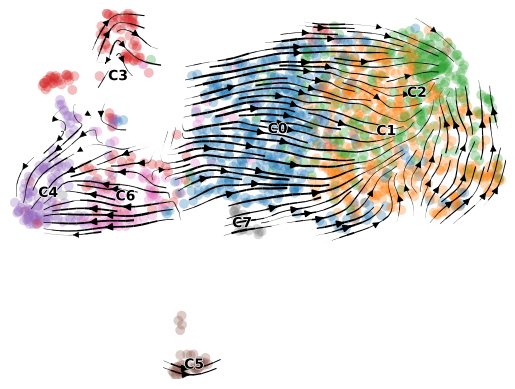

In [240]:
scv.pl.velocity_embedding_stream(adata, basis='umap', color=['cluster'], size=200, title='')